## Data exploration

In [44]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# This package will output the execution time of each cell. Pretty neat!
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

/Users/johnspencer/kingdom/5th_year_2016/csc599_data_science/anaconda3/lib/python3.5/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.36 s


### Let's grab the data from [September, 2016](https://s3.amazonaws.com/tripdata/201609-citibike-tripdata.zip)

In [30]:
rides = pd.read_csv('data/201606-citibike-tripdata.csv')

time: 4.84 s


### How does the data look?

In [31]:
rides.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


time: 31.1 ms


### Looks good! How much data do we have?

In [32]:
num_rides = len(rides)
num_female = len(rides[rides['gender'] == 2])
percent_female = (num_female / num_rides) * 100
num_male = len(rides[rides['gender'] == 1])
percent_male = (num_male / num_rides) * 100
print(("Our data set has %d rides, " +
      "of which %.2f%% (%d) are female and %.2f%% (%d) are male") % (
        len(rides), percent_female, num_female, percent_male, num_male))

Our data set has 1460318 rides, of which 21.54% (314618) are female and 64.88% (947464) are male
time: 297 ms


In [33]:
len(rides[(rides['tripduration'] / 60) > 50])

22416

time: 32.5 ms


### What are the most popular starting stations?

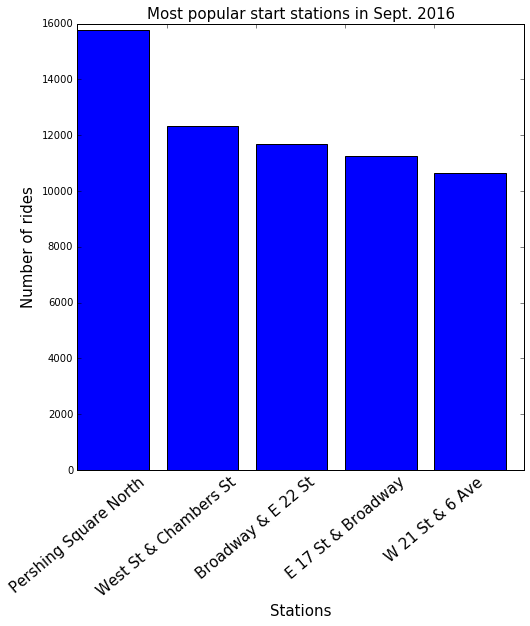

time: 544 ms


In [34]:
start_stations = rides.groupby('start station name')['start station id'].count().reset_index()
start_stations.columns = ['Start Station', 'Count']
start_stations = start_stations.sort_values(by='Count', ascending=False).head()

# create bar graph
plt.figure(figsize=(8,8))
plt.bar(list(range(len(start_stations))), start_stations['Count'], 
            tick_label=start_stations['Start Station'])
plt.xticks(rotation=40, fontsize = 15)
plt.xlabel('Stations', fontsize = 15)
plt.ylabel('Number of rides', fontsize = 15)
plt.title('Most popular start stations in Sept. 2016', fontsize = 15)
print()

### What are the most popular ending stations?

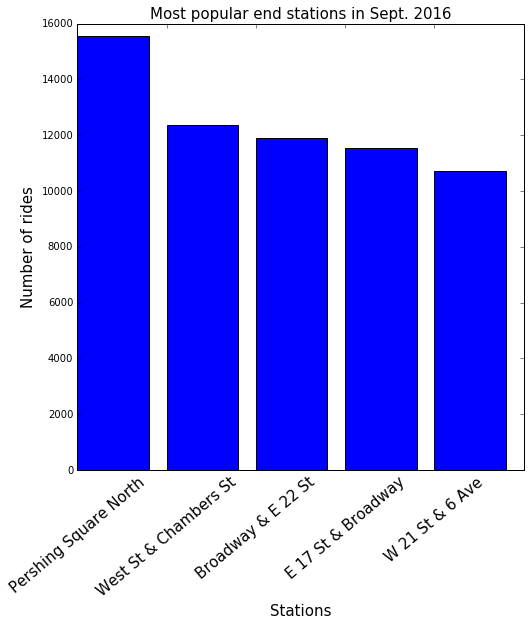

time: 668 ms


In [35]:
end_stations = rides.groupby('end station name')['end station id'].count().reset_index()
end_stations.columns = ['End Station', 'Count']
end_stations = end_stations.sort_values(by='Count', ascending=False).head()

# create bar graph
plt.figure(figsize=(8,8))
plt.bar(list(range(len(end_stations))), end_stations['Count'], 
            tick_label=end_stations['End Station'])
plt.xticks(rotation=40, fontsize = 15)
plt.xlabel('Stations', fontsize = 15)
plt.ylabel('Number of rides', fontsize = 15)
plt.title('Most popular end stations in Sept. 2016', fontsize = 15)
print()

### Looks like just about the same as the most popular start stations!

### How about, what percentage of rides are one-way vs. round trip?

In [36]:
round_trip = rides[rides['start station id'] == rides['end station id']]
percent_round_trip = (len(round_trip) / len(rides)) * 100
print("Round trips account for %.2f%% of bike rides (in September)" % percent_round_trip)

Round trips account for 2.11% of bike rides (in September)
time: 36.3 ms


### What about in other months?

In [37]:
aug_2016_rides = pd.read_csv('data/201608-citibike-tripdata.csv')

time: 5.22 s


In [38]:
aug_2016_round_trip = aug_2016_rides[aug_2016_rides['start station id'] == aug_2016_rides['end station id']]
aug_2016_percent_round_trip = (len(aug_2016_round_trip) / len(aug_2016_rides)) * 100
print("Round trips account for %.2f%% of bike rides (in October)" % aug_2016_percent_round_trip)

Round trips account for 2.22% of bike rides (in October)
time: 59.7 ms


### Okay, so clearly "round trips" account for a very small portion of rides. Will this be viable to use to classify the data? Maybe note. But our version of round trips means starting and stopping at the same station. But stations can be very nearby each other, especially in the village:
<img src="data/citi_bike_stations.png" style="height: 800px">

### So a user may make basically a "round trip" but then return the bike to a station one block away. We should treat this as a round trip when analyzing our data. We have longitude and latitudate data from each station, let's use that!

In [39]:
from geopy.distance import great_circle

time: 1.88 ms


### Let's see how the module works

In [40]:
start = (aug_2016_rides.iloc[0]['start station longitude'], aug_2016_rides.iloc[0]['start station latitude'])
end = (aug_2016_rides.iloc[0]['end station longitude'], aug_2016_rides.iloc[0]['end station latitude'])
print("Start station: %s" % str(start))
print("End station: %s" % str(end))
print("Distance between: %.4f %s" % (great_circle(start, end).miles, "miles"))

Start station: (-73.977931720000001, 40.720828339999997)
End station: (-73.987834129999996, 40.724677210000003)
Distance between: 0.6883 miles
time: 4.27 ms


In [41]:
start = (aug_2016_rides.iloc[1]['start station longitude'], aug_2016_rides.iloc[1]['start station latitude'])
end = (aug_2016_rides.iloc[1]['end station longitude'], aug_2016_rides.iloc[1]['end station latitude'])
print("Start station: %s" % str(start))
print("End station: %s" % str(end))
print("Distance between: %.4f %s" % (great_circle(start, end).miles, "miles"))

Start station: (-73.990741420000006, 40.734545670000003)
End station: (-73.983798550000003, 40.72621788)
Distance between: 0.5054 miles
time: 4.53 ms


In [65]:
xrange = 100000
count = 0
data = aug_2016_rides[aug_2016_rides['usertype'] == 'Subscriber']
for i in range(len(data.iloc[:xrange])):
    start_coordinates = (data.iloc[i]['start station longitude'], data.iloc[i]['start station latitude'])
    end_coordinates = (data.iloc[i]['end station longitude'], data.iloc[i]['end station latitude'])
    distance = great_circle(start_coordinates, end_coordinates).miles
    if (distance < 5) & (data.iloc[i]['tripduration'] > 300):
        count += 1

aug_2016_percent_round_trip = (count / xrange) * 100
print("Out of %d rides in Aug 2016, %d%% are round trip" % (xrange, aug_2016_percent_round_trip))

Out of 100000 rides in Aug 2016, 84% are round trip
time: 1min 15s
